# Step 5: Recommender System

To implement the image recommendation functionality for our project, we are following these steps:

1. Image Classification: Utilize our existing machine learning model to classify the user-provided reference image into one of the eight flower classes.
2. Similarity Detection:
    - Construct a Convolutional Neural Network (CNN) to extract feature vectors from images
    - For each image in our database use this CNN to extract its feature vector, then store it in `./data/recommender-database.csv`, to allow for efficient retrieval during the recommendation process.
    - Use the same CNN to extract a feature vector from our the user-provided reference image.
    - Apply a K-Means unsupervised machine learning model to cluster the reference image's feature vector with those of the images in our database. We select the number of cluster $k$ dynamically using the number of images need to be recommended.
3. Recommending Images: Once we have the clusters, we would recommend images from the cluster that the reference image belongs to. To do this accurately, we are using [Scikit-learn implementation of cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find the most similar images to the reference image within that cluster.

In [1]:
# Imports and environmental setups

import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import joblib


# Custom utils functions
from utils import dataset
from utils import data_manip as manip
from utils.glob import TARGET_IMG_SIZE
from classify import classify


# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
dir_raw_dataset = '../data/raw/'
dir_recommender_database = '../data/recommender-database/'
path_recommender_database = '../data/recommender-database.csv'
dir_models = '../models/'

path_model_clf = '../models/clf-cnn'
model_feature_extractor_name = 'fe-cnn'
path_model_feature_extractor = dir_models + model_feature_extractor_name
model_clustering_name = 'clu-kmeans'
path_model_clustering = dir_models + model_clustering_name + '.model'


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


## 5.1. Feature Extractor - CNN

In [2]:
# Model Parameters
INPUT_DIM = (TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)  # RGB - 3 channels images
FEATURE_VEC_DIM = 16

In [3]:
feature_extractor = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(FEATURE_VEC_DIM),
], name=model_feature_extractor_name)

feature_extractor.compile(optimizer='adam', loss='mse')

In [4]:
feature_extractor.summary()

Model: "fe-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      32832     
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 64)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 128)               30482

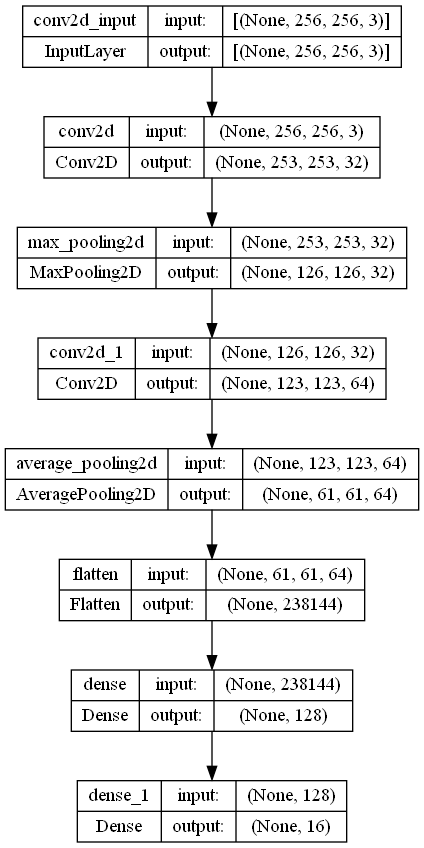

In [5]:
tf.keras.utils.plot_model(feature_extractor, show_shapes=True, to_file=f'images/{model_feature_extractor_name}-Diagram.png')

**Model Export:**

In [6]:
feature_extractor.save(path_model_feature_extractor, overwrite=True)

INFO:tensorflow:Assets written to: ../models/fe-cnn\assets


INFO:tensorflow:Assets written to: ../models/fe-cnn\assets


## 5.2. Recommender Database: Feature Extraction

- Load all image in `./data/recommender-database/`.
- Extract their feature vectors using our feature extractor defined above.
- Save them in `./data/recommender-database.csv`

In [7]:
recommendations = {'ImgPath': [], 'Class': []}
for j in range(FEATURE_VEC_DIM):
    recommendations[f'x{j}'] = []

In [8]:
df = dataset.load(dir_recommender_database)
print(f'Number of images in database: {df.shape[0]}')

Number of images in database: 4685


In [9]:
with tqdm(total=len(df), desc='Extracting feature vectors from recommender-database', position=0, leave=True) as pbar:
    for i, row in df.iterrows():
        pbar.update()
        recommendations['ImgPath'].append(row['ImgPath'])
        recommendations['Class'].append(row['Class'])
        with Image.open(f'{dir_recommender_database}{recommendations["ImgPath"][-1]}') as ref:
            ref_processed = manip.resize_crop(ref, TARGET_IMG_SIZE, TARGET_IMG_SIZE)
            ref_processed = manip.normalize_pixels(ref_processed)
            ref_processed = tf.expand_dims(ref_processed, axis=0)

            ref_feature_vector = feature_extractor.predict(ref_processed, verbose=0)
            for j, feature in enumerate(ref_feature_vector.reshape(-1)):
                recommendations[f'x{j}'].append(feature)

Extracting feature vectors from recommender-database:   0%|          | 0/4685 [00:00<?, ?it/s]

In [10]:
df_feature_vectors = pd.DataFrame(recommendations)
df_feature_vectors.to_csv(path_recommender_database, index=False)

## 5.3. Clustering Model

K-Means with K-Means++ initialization and dynamic k selection:

In [11]:
clu = KMeans(init='k-means++', n_init='auto')

**Model Export:**

In [12]:
joblib.dump(clu, path_model_clustering)

['../models/clu-kmeans.model']

## 5.4. Example Recommendation for Sample Images

We are using 4 random reference images from `./data/raw/`. For each of them, we will determine their class (flower type) and recommend 3 similar images of the same class (this process can scale up to any non zero positive integer number of recommendation, only limited by the number of images we have in our database).

### 5.4.1. Load 4 Random Reference Images from Raw dataset

In [13]:
df_raw = dataset.load(dir_raw_dataset)
df_sample_ref_img_paths = df_raw.sample(4, random_state=21)['ImgPath']

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
for i, ref_path in enumerate(df_sample_ref_img_paths):
    with Image.open(f'{dir_raw_dataset}{ref_path}') as ref:
        ax[i].imshow(ref)
        ax[i].set_title(ref_path, fontsize=12)
        ax[i].axis('off')

plt.show()

### 5.4.2. Load saved Feature Extractor and Clustering Models

In [15]:
fe = tf.keras.models.load_model(path_model_feature_extractor)
clu = joblib.load(path_model_clustering)

In [16]:
fe.summary()

Model: "fe-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      32832     
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 64)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 128)               30482

In [17]:
print(clu)

KMeans(n_init='auto')


### 5.4.3. Load Recommender Database

In [18]:
df_rec = pd.read_csv(path_recommender_database)

In [19]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ImgPath  4685 non-null   object 
 1   Class    4685 non-null   object 
 2   x0       4685 non-null   float64
 3   x1       4685 non-null   float64
 4   x2       4685 non-null   float64
 5   x3       4685 non-null   float64
 6   x4       4685 non-null   float64
 7   x5       4685 non-null   float64
 8   x6       4685 non-null   float64
 9   x7       4685 non-null   float64
 10  x8       4685 non-null   float64
 11  x9       4685 non-null   float64
 12  x10      4685 non-null   float64
 13  x11      4685 non-null   float64
 14  x12      4685 non-null   float64
 15  x13      4685 non-null   float64
 16  x14      4685 non-null   float64
 17  x15      4685 non-null   float64
dtypes: float64(16), object(2)
memory usage: 659.0+ KB


### 5.4.4. Classify and Recommend

In [20]:
num_recommendations = 4  # Will be provided by the user in the client code
k = int(np.sqrt(len(df_rec) / num_recommendations))
clu.set_params(n_clusters=k)

KMeans(n_clusters=34, n_init='auto')

In [21]:
results = []
for ref_path in df_sample_ref_img_paths:
    with Image.open(f'{dir_raw_dataset}{ref_path}') as ref:
        # Classify reference image
        ref_processed, ref_class = classify(f'{dir_raw_dataset}{ref_path}', classifier_path=path_model_clf, return_original=False)
        recommendations = df_rec[df_rec['Class'] == ref_class]

        # Extract reference image feature vector
        ref_processed = np.squeeze(ref_processed)
        ref_feature_vector = fe.predict(
            tf.expand_dims(ref_processed, axis=0),
            verbose=0
        )
        ref_feature_vector = ref_feature_vector.astype(float)
        ref_feature_vector = ref_feature_vector.reshape(1, -1)

        # Cluster reference image
        clu.fit(recommendations.drop(['ImgPath', 'Class'], axis='columns').values)
        ref_cluster = clu.predict(ref_feature_vector)
        ref_cluster_indices = np.where(clu.labels_ == ref_cluster)[0]
        recommendations = recommendations.iloc[ref_cluster_indices]

        # Rank cluster and produce top cosine similarity recommendations
        cosine_similarities = cosine_similarity(ref_feature_vector, recommendations.drop(['ImgPath', 'Class'], axis='columns'))
        sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())  # Updated line
        top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
        recommendations = recommendations.iloc[top_ref_cluster_indices]

        results.append(recommendations['ImgPath'].values)
print(results)

[array(['Chrysanthemum/chrysanthemum_595.jpg',
       'Chrysanthemum/chrysanthemum_635.jpg',
       'Chrysanthemum/chrysanthemum_145.jpg',
       'Chrysanthemum/chrysanthemum_609.jpg'], dtype=object), array(['Calimerio/calimero_121.jpg', 'Calimerio/calimero_284.jpg',
       'Calimerio/000068.jpg', 'Calimerio/000077.jpg'], dtype=object), array(['Chrysanthemum/000030.jpg', 'Chrysanthemum/000023.jpg',
       'Chrysanthemum/000016.jpg', 'Chrysanthemum/000050.jpg'],
      dtype=object), array(['Baby/000015.jpg', 'Baby/baby_434.jpg', 'Baby/000008.jpg',
       'Baby/baby_518.jpg'], dtype=object)]


### 5.4.5. Recommendation Results Visualization

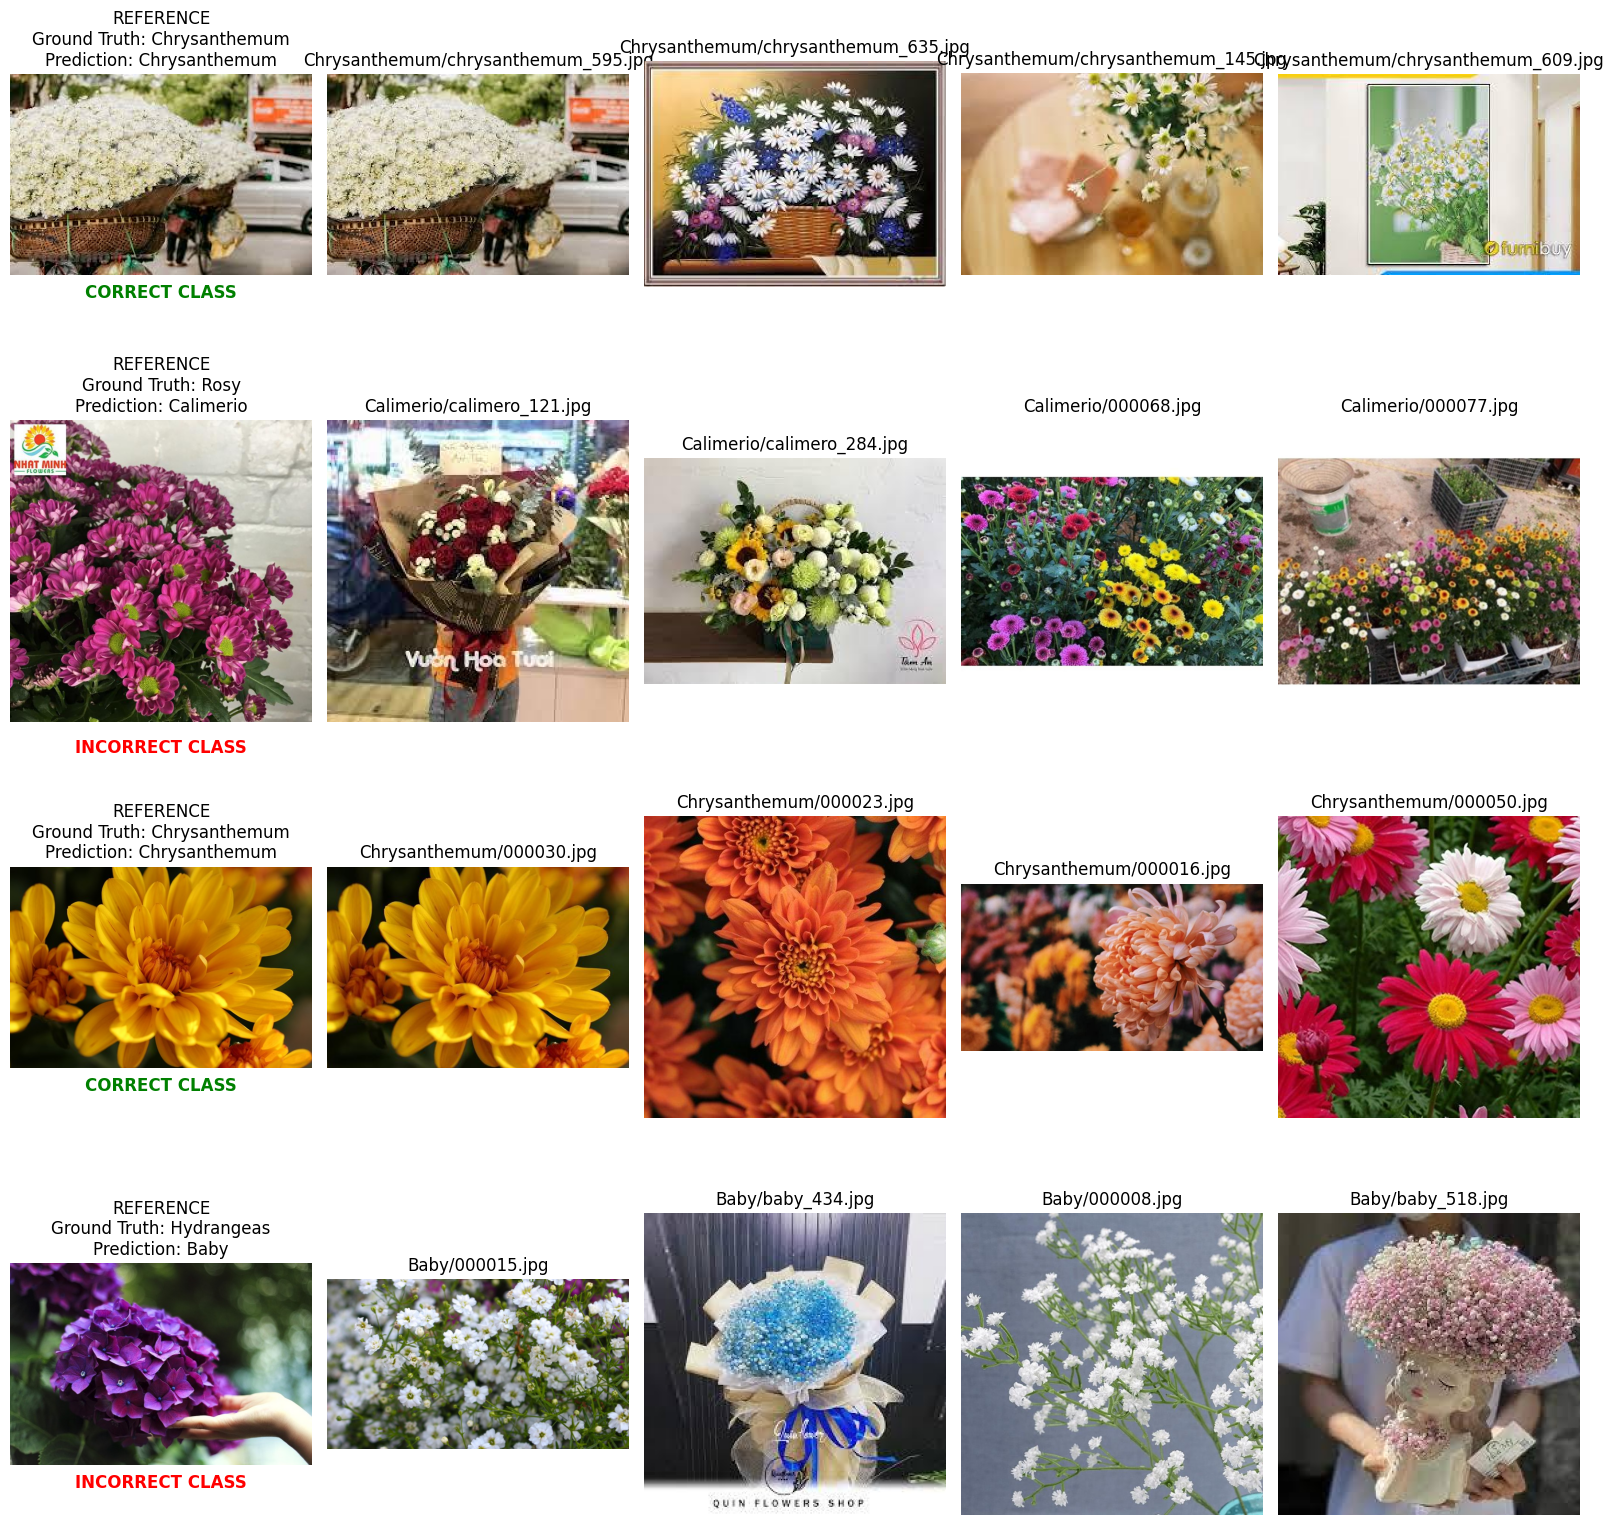

In [22]:
fig, ax = plt.subplots(4, 5, figsize=(16, 16))
for i, ref_path in enumerate(df_sample_ref_img_paths):
    with Image.open(f'{dir_raw_dataset}{ref_path}') as ref:
        true_label = ref_path.split('/')[0]
        _, predicted_label = classify(f'{dir_raw_dataset}{ref_path}', classifier_path=path_model_clf)

        ax[i][0].imshow(ref)
        ax[i][0].set_title(
            f'REFERENCE\n'
            f'Ground Truth: {true_label}\n'
            f'Prediction: {predicted_label}',
            fontsize=12
        )
        ax[i][0].text(
            0.5, -0.08, f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
            horizontalalignment='center',
            verticalalignment='center_baseline',
            transform=ax[i][0].transAxes,
            fontsize=12,
            color='green' if true_label == predicted_label else 'red',
            weight='bold'
        )
        ax[i][0].axis('off')

    for j, rec_path in enumerate(results[i], start=1):
        with Image.open(f'{dir_recommender_database}{rec_path}') as rec:
            ax[i][j].imshow(rec)
            ax[i][j].set_title(rec_path, fontsize=12)
            ax[i][j].axis('off')


plt.tight_layout()
plt.show()
fig.savefig('images/Recommender-Example-Results.png')

**☞ Observation**

We can see that our approach is successful in effectively and accurately recommending images based on a reference image given by the user, provided that our classification model produces the correct class label from the reference image. As such, our recommendation system performance is limited by our classification model's performance.